In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

In [25]:
import numpy as np

In [26]:
import sys
sys.path.append('..')

from my_code import functions as f

# Data

In [27]:
file_path = '../data/energies/Trial/Strings_Energies_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/100
angles_list = np.array([f.string_to_numbers(string) for string in string_list])

In [28]:
X, Y, X_validation, Y_validation = f.create_validating_set(angles_list, score_list, percentage=0.1)

In [29]:
# Define the dataset
input_data = torch.tensor(X, dtype=torch.float32)
target_data = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

# Define the validation set
input_validation = torch.tensor(X_validation, dtype=torch.float32)
target_validation = torch.tensor(Y_validation, dtype=torch.float32).view(-1, 1)

# Quantum node

In [30]:
import pennylane as qml

In [31]:
def qml_RZZ(params, wires):
    """
    RZZ gate.
    """
    qml.CNOT(wires=wires)
    qml.RZ(params, wires=wires[1])
    qml.CNOT(wires=wires)

In [32]:
n_qubits = 4
n_layers_block = 50
n_layers_embedding = 3
n_layers = n_layers_block + n_layers_embedding
n_params = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):

    # state preparation (we create an embedding with 3 layers, paper: 2001.03622)
    for i in range(n_layers_embedding):
       
        # angle embedding for each qubit
        qml.AngleEmbedding(inputs, wires=range(n_qubits))

        # ZZ rotation for neighboring qubits         
        for x in range(2):
            for j in range(x,n_qubits,2): 
                qml_RZZ(weights[i,j,0], wires=[j, (j+1)%n_qubits])

        # rotations for each qubit
        for j in range(n_qubits):
            qml.RY(weights[i,j,1], wires=j)

        # last angle embedding
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    #layers
    for i in range(n_layers_embedding, n_layers):
        # rotations for each qubit
        for j in range(n_qubits):
            qml.RX(weights[i,j,2], wires=j)
            qml.RZ(weights[i,j,3], wires=j)

        # ZZ rotation for neighboring qubits 
        for x in range(2):
            for j in range(x,n_qubits,2): 
                qml_RZZ(weights[i,j,4], wires=[j, (j+1)%n_qubits])

    # last rotation for each qubit
    for j in range(n_qubits):
        qml.RX(weights[n_layers,j,2], wires=j)
        qml.RZ(weights[n_layers,j,3], wires=j)

    # measurement
    return [qml.expval(qml.PauliZ(wires=0))]

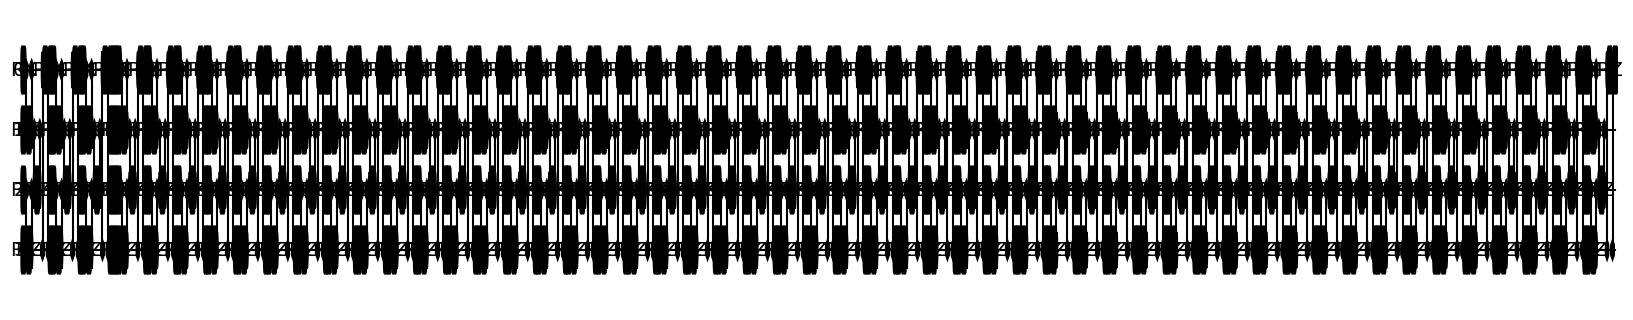

In [33]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode, expansion_strategy="device")([i for i in range(n_qubits)], np.zeros((n_layers, n_qubits, n_params)))
fig.set_size_inches((16,3))

In [34]:
weight_shapes = {"weights": (n_layers, n_qubits, n_params)}

In [35]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Hybrid model

In [36]:
class MultiplyBy10Layer(nn.Module):
    def __init__(self):
        super(MultiplyBy10Layer, self).__init__()

    def forward(self, x):
        return x * 10

In [37]:
input_dim = input_data.size(1)

layers =  [nn.Linear(input_dim*1, input_dim*2), nn.ReLU()]
layers += [nn.Linear(input_dim*2, input_dim*3), nn.ReLU()] 
layers += [nn.Linear(input_dim*3, input_dim*3), nn.ReLU()] 
layers += [nn.Linear(input_dim*3, input_dim*2), nn.ReLU()] 
layers += [nn.Linear(input_dim*2, input_dim*1)] 
layers += [qlayer] 
layers += [nn.Linear(1, 10), nn.ReLU()] 
layers += [nn.Linear(10, 20), nn.ReLU()] 
layers += [nn.Linear(20, 20), nn.ReLU()] 
layers += [nn.Linear(20, 10), nn.ReLU()] 
layers += [nn.Linear(10, 1)] 
Net = nn.Sequential(*layers)

In [38]:
# Create an instance of the network
model = Net

In [39]:
import time

In [40]:
# time
start_time = time.time()


# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10
batch_size = 32

losses = []
losses_epochs = []

for epoch in range(num_epochs):
    # Shuffle the dataset
    indices = torch.randperm(input_data.size(0))
    input_data = input_data[indices]
    target_data = target_data[indices]

    losses_epochs.append(0)

    # Mini-batch training
    for i in range(0, input_data.size(0), batch_size):
        inputs = input_data[i:i+batch_size]
        targets = target_data[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss
        losses.append(loss.item())

        print('- Epoch [{}/{}], i: [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, input_data.size(0), loss.item()), end='\r')

        # add to the epoch loss
        losses_epochs[-1] += loss.item() 

    # divide the epoch loss by the number of batches, to get the average loss
    losses_epochs[-1] /= (input_data.size(0)/batch_size)

    # time
    # Compute elapsed time and remaining time
    elapsed_time = time.time() - start_time
    avg_time_per_epoch = elapsed_time / (epoch + 1)
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_remaining_time = avg_time_per_epoch * remaining_epochs

    # Convert remaining time to hours, minutes, and seconds for better readability
    hours, remainder = divmod(estimated_remaining_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Print the loss and remaining time for this epoch
    print('Epoch [{}/{}], Loss: {:.4f}, Time remaining: ~{}h {}m {:.0f}s'.format(
        epoch+1, num_epochs, losses_epochs[-1], hours, minutes, seconds))


Epoch [1/10], Loss: 5.5618, Time remaining: ~0.0h 36.0m 6s
Epoch [2/10], Loss: 5.5392, Time remaining: ~0.0h 30.0m 5s
Epoch [3/10], Loss: 5.5148, Time remaining: ~0.0h 25.0m 39s
Epoch [4/10], Loss: 5.5490, Time remaining: ~0.0h 21.0m 44s
Epoch [5/10], Loss: 5.5141, Time remaining: ~0.0h 17.0m 58s
Epoch [6/10], Loss: 5.5125, Time remaining: ~0.0h 14.0m 18s
Epoch [7/10], Loss: 5.5454, Time remaining: ~0.0h 10.0m 41s
Epoch [8/10], Loss: 5.5159, Time remaining: ~0.0h 7.0m 7s
Epoch [9/10], Loss: 5.5145, Time remaining: ~0.0h 3.0m 33s
Epoch [10/10], Loss: 5.5150, Time remaining: ~0.0h 0.0m 0s


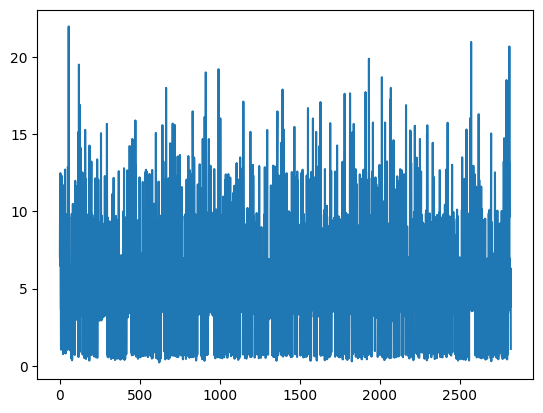

In [41]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

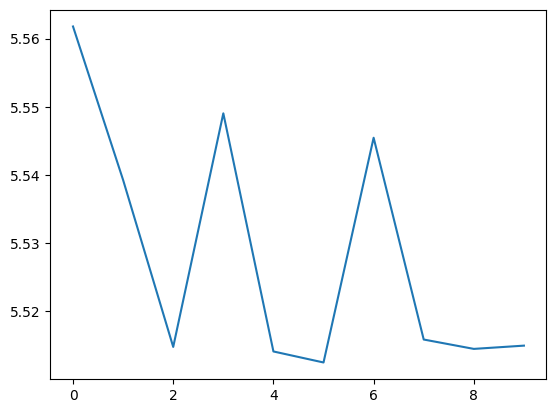

In [42]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses_epochs)
plt.show()

In [43]:
avg_loss = 0
for x, (i, t) in enumerate(zip((input_validation), target_validation)):
    loss = criterion(model(i), t)
    avg_loss += loss/len(target_validation)
    print('i: {}, \t\t target: {:.3f}, \t output: {:.3f}, \t loss: {:.3f}'.format(x, t.item(), model(i).item(), loss))

print('Average loss: {:.3f}'.format(avg_loss))

i: 0, 		 target: 9.605, 	 output: -0.426, 	 loss: 100.630
i: 1, 		 target: -2.105, 	 output: -0.426, 	 loss: 2.818
i: 2, 		 target: -0.602, 	 output: -0.426, 	 loss: 0.031
i: 3, 		 target: -2.850, 	 output: -0.426, 	 loss: 5.875
i: 4, 		 target: -1.463, 	 output: -0.426, 	 loss: 1.075
i: 5, 		 target: 0.584, 	 output: -0.426, 	 loss: 1.021
i: 6, 		 target: -0.426, 	 output: -0.426, 	 loss: 0.000
i: 7, 		 target: -1.380, 	 output: -0.426, 	 loss: 0.909
i: 8, 		 target: -2.627, 	 output: -0.426, 	 loss: 4.845
i: 9, 		 target: -1.413, 	 output: -0.426, 	 loss: 0.975
i: 10, 		 target: -1.229, 	 output: -0.426, 	 loss: 0.644
i: 11, 		 target: -0.365, 	 output: -0.426, 	 loss: 0.004
i: 12, 		 target: -1.394, 	 output: -0.426, 	 loss: 0.937
i: 13, 		 target: -1.380, 	 output: -0.426, 	 loss: 0.910
i: 14, 		 target: -0.753, 	 output: -0.426, 	 loss: 0.107
i: 15, 		 target: -2.112, 	 output: -0.426, 	 loss: 2.840
i: 16, 		 target: -0.548, 	 output: -0.426, 	 loss: 0.015
i: 17, 		 target: -1.637

# Save the Notebook as a PDF

In [44]:
# SAVE THE NOTEBOOK

from IPython.display import Javascript

# Define the function to save the notebook
def save_notebook():
    display(Javascript('IPython.notebook.save_notebook()'))

# Call the save_notebook function to save the notebook
save_notebook()

<IPython.core.display.Javascript object>

In [45]:
import subprocess
import os

name_notebook = "0725-small_hybrid_model_1q_measurement.ipynb"  

output_filename = "results/"+ name_notebook[:4] +"/" + name_notebook[:-6] + "_0.pdf"

#check if the output file already exists
while os.path.exists(output_filename):
    print("The file {} already exists".format(output_filename))
    output_filename = output_filename[:-5] + str(int(output_filename[-5]) + 1) + ".pdf"
    print("Trying to save the file as {}".format(output_filename))
    

subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", output_filename, name_notebook])




The file results/0725/0725-small_hybrid_model_1q_measurement_0.pdf already exists
Trying to save the file as results/0725/0725-small_hybrid_model_1q_measurement_1.pdf
The file results/0725/0725-small_hybrid_model_1q_measurement_1.pdf already exists
Trying to save the file as results/0725/0725-small_hybrid_model_1q_measurement_2.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'results/0725/0725-small_hybrid_model_1q_measurement_2.pdf', '0725-small_hybrid_model_1q_measurement.ipynb'], returncode=0)